### Imports

In [120]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, learning_curve
from sklearn import metrics
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV
import dtreeviz

# https://www.scikit-yb.org/
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Avoiding warnings to pop up
import warnings
warnings.filterwarnings("ignore")

# Set aspects of the visual theme for all matplotlib and seaborn plots.
sns.set()

os.getcwd()

'/Users/sergeykorepanov/PycharmProjects/pythonProject'

# Understanding the Dataset

Let's look at the first few rows of the dataset
Even from this small sample we can see a lot of missing data and data that is not relevant.

For example some of the job postings are missing `salary data` which is very important for our project.


In [3]:
df = pd.read_csv('./content/sample_data/us-software-engineer-jobs-zenrows.csv')
df.head()

,title,company,salary,rating,review_count,types,location,relative_time,hires_needed,hires_needed_exact,...,indeed_applyable,ad_id,remote_location,source_id,hiring_event_job,indeed_apply_enabled,job_location_postal,company_overview_link,activity_date,location_extras
0,Android Developer,Shockoe,NaN,0.0,0,Full-time,"Richmond, VA",30+ days ago,NaN,NaN,...,False,NaN,False,11706594,False,False,NaN,NaN,NaN,NaN
1,Web Developer,"Denios, Inc.","$45,000 - $55,000 a year",0.0,0,Full-time,"Louisville, KY",30+ days ago,ONE,1,...,True,370154371.0,False,11468052,False,True,40219.0,NaN,Active 2 days ago,NaN
2,Sr. Android Developer,The Cervantes Group,NaN,4.1,22,Full-time,Remote,6 days ago,TWO_FOUR,2,...,True,NaN,False,9570478,False,True,NaN,/cmp/The-Cervantes-Group,Active 3 days ago,NaN
3,Junior Software Engineer,Medical Knowledge Group,NaN,0.0,0,Full-time,Remote,8 days ago,ONE,1,...,True,368864426.0,False,501562,False,True,NaN,NaN,Active 3 days ago,NaN
4,"Cloud Engineer (Software Engineer Advanced, Ex...",Federal Reserve Bank of New York,NaN,4.1,548,Full-time,"Kansas City, MO",2 days ago,NaN,NaN,...,False,NaN,False,1439,False,False,NaN,/cmp/Federal-Reserve-Bank-of-New-York,NaN,NaN


## Information about data set

From the information we are able to see all type of data in our disposal.
Let list a few of them that are more important to us and describe their meaning



*   **Title** - title of the job position on which company is hiring
*   **Company** - name of the company that is hiring
*   **Salary** - Salary range that the company is offering for the position
*   **Location** - Location where the office of the company is located
*   **Types** - Type of employment: Full-time, Part-time, Contract, Internship, Temporary

Other data points are considered unrelated for our goals. Therefore, let's remove them.



In [4]:
df.info()
columns_to_drop = ['rating', 'review_count', 'relative_time', 'hires_needed', 'hires_needed_exact',
                   'remote_work_model', 'snippet', 'dradis_job', 'link', 'new_job',
                   'job_link', 'featured_employer', 'indeed_applyable', 'ad_id', 'remote_location',
                   'source_id', 'hiring_event_job', 'indeed_apply_enabled', 'job_location_postal', 'company_overview_link',
                   'activity_date', 'location_extras']
df_cleaned = df.drop(columns_to_drop, axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58433 entries, 0 to 58432
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  58433 non-null  object 
 1   company                58430 non-null  object 
 2   salary                 18103 non-null  object 
 3   rating                 58433 non-null  float64
 4   review_count           58433 non-null  int64  
 5   types                  42577 non-null  object 
 6   location               58433 non-null  object 
 7   relative_time          58433 non-null  object 
 8   hires_needed           11857 non-null  object 
 9   hires_needed_exact     18439 non-null  object 
 10  urgently_hiring        58433 non-null  bool   
 11  remote_work_model      22804 non-null  object 
 12  snippet                58425 non-null  object 
 13  dradis_job             58433 non-null  bool   
 14  link                   58433 non-null  object 
 15  ne

## Cleaned Data Set
Here is the data remained after cleaning

In [5]:
df_cleaned.head()

,title,company,salary,types,location,urgently_hiring,sponsored
0,Android Developer,Shockoe,NaN,Full-time,"Richmond, VA",False,False
1,Web Developer,"Denios, Inc.","$45,000 - $55,000 a year",Full-time,"Louisville, KY",True,True
2,Sr. Android Developer,The Cervantes Group,NaN,Full-time,Remote,False,False
3,Junior Software Engineer,Medical Knowledge Group,NaN,Full-time,Remote,True,True
4,"Cloud Engineer (Software Engineer Advanced, Ex...",Federal Reserve Bank of New York,NaN,Full-time,"Kansas City, MO",False,False


## Normalising Data
After we cleaned irrelevant data we need to normalise salary ranges. In the code snippet bellow we can see that salary range for a position can be stated as "a year", "a month", "a week", "an hour"

- First of all we will convert salary data to dollars per year.

- And after we will split range data to min_salary and max_salary for the role

### Converting Salary Data
let's look at the unique values in the 'salary' column to understand the data better

In [6]:
# Get unique values after dropping NaNs
unique_salaries = set(df_cleaned['salary'].unique())
unique_salaries_df = pd.DataFrame(unique_salaries)
unique_salaries_df.head(n=100)

,0
0,NaN
1,"$99,900 a year"
2,"$55,000 - $65,000 a year"
3,"Up to $162,500 a year"
4,"$116,000 - $140,000 a year"
...,...
95,$52 - $62 an hour
96,"Up to $13,000 a year"
97,"$60,000 - $72,000 a year"
98,"$70,000 - $95,000 a year"


### Converting to Yearly Salary
From previous snippet we see that the salary appears in different formats and rates. 
- a year, a month, a week, an hour
- range and fixed rate

- Let's try to convert all of them to yearly salary

In [7]:
# Cleaning symbols
def clean_text(text: str):
    if pd.isna(text):
        return "NaN"
    # Split the text by ' - ' to separate the salary range
    cleaned_text = (text
                    .lower()
                    .replace('$', '')
                    .replace(',', '')
                    .replace(' - ', ' '))

    return cleaned_text

df_cleaned['salary_temp'] = df_cleaned['salary'].apply(clean_text)

df_cleaned['salary_temp']

0                       NaN
1        45000 55000 a year
2                       NaN
3                       NaN
4                       NaN
                ...        
58428                   NaN
58429                   NaN
58430                   NaN
58431                   NaN
58432                   NaN
Name: salary_temp, Length: 58433, dtype: object

In [8]:
# Define the assumption for hours worked per year
hours_per_year = 1892  # Statistical data from clockify 

def convert_range_match(match: re.Match[str]) -> object:
    if match.group(3) == 'a year':
        yearly_min = float(match.group(1))
        yearly_max = float(match.group(2))
    if match.group(3) == 'a month':
        yearly_min = float(match.group(1)) * 12
        yearly_max = float(match.group(2)) * 12
    if match.group(3) == 'a week':
        yearly_min = float(match.group(1)) * 52
        yearly_max = float(match.group(2)) * 52
    if match.group(3) == 'a day':
        yearly_min = float(match.group(1)) * 260
        yearly_max = float(match.group(2)) * 260    
    if match.group(3) == 'an hour':
        yearly_min = float(match.group(1)) * hours_per_year
        yearly_max = float(match.group(2)) * hours_per_year        
    return f"{yearly_min:.0f} {yearly_max:.0f}"

def convert_fixed_match(match: re.Match[str]) -> object:
    if match.group(2) == 'a year':
        yearly_min = float(match.group(1))
        yearly_max = yearly_min
    if match.group(2) == 'a month':
        yearly_min = float(match.group(1)) * 12
        yearly_max = yearly_min
    if match.group(2) == 'a week':
        yearly_min = float(match.group(1)) * 52
        yearly_max = yearly_min
    if match.group(2) == 'a day':
        yearly_min = float(match.group(1)) * 260
        yearly_max = yearly_min    
    if match.group(2) == 'an hour':
        yearly_min = float(match.group(1)) * hours_per_year
        yearly_max = yearly_min        
    return f"{yearly_min:.0f} {yearly_max:.0f}"

def converter(salary: str):
    if salary == 'NaN':
        return salary
    
    range_pattern = r'(\d+\.?\d*) (\d+\.?\d*) (a year|a month|an hour|a week|a day)'
    fixed_pattern = r'(\d+\.?\d*) (a year|a month|an hour|a week|a day)'
    
    range_match = re.search(range_pattern, salary)
    fixed_match = re.search(fixed_pattern, salary)
    
    if range_match:
        return convert_range_match(range_match)

    if fixed_match:
        return convert_fixed_match(fixed_match)
# Apply the function to the 'salary' column
df_cleaned['salary_temp'] = df_cleaned['salary_temp'].apply(converter)
df_cleaned['salary_temp']

salary_split = df_cleaned['salary_temp'].str.split(expand=True)

# Assigning the split parts to 'min_salary' and 'max_salary' columns
df_cleaned['min_salary'] = salary_split[0]
df_cleaned['max_salary'] = salary_split[1]

df_cleaned.drop(columns='salary_temp', inplace=True)
dataframe = df_cleaned.dropna(subset="salary")

dataframe.loc[:, 'min_salary'] = dataframe['min_salary'].astype(int, copy=True)
dataframe.loc[:, 'max_salary'] = dataframe['max_salary'].astype(int, copy=True)
dataframe['avg_salary'] = dataframe[['min_salary', 'max_salary']].mean(axis=1).astype(int, copy=True)

dataframe

,title,company,salary,types,location,urgently_hiring,sponsored,min_salary,max_salary,avg_salary
1,Web Developer,"Denios, Inc.","$45,000 - $55,000 a year",Full-time,"Louisville, KY",True,True,45000,55000,50000
7,"Real-Time, Embedded Software Engineer",Checkmate Partners,"$100,000 - $200,000 a year",Full-time,"San Francisco Bay Area, CA",False,True,100000,200000,150000
13,Software Engineer (Clearance Required),LOCKHEED MARTIN CORPORATION,"$3,000 a week",NaN,"Annapolis Junction, MD",False,False,156000,156000,156000
14,Cyber Security Operation Center Manager (SOC),Goliath Solutions Group,$15 - $20 an hour,Full-time,"Fairview, TX",True,True,28380,37840,33110
17,DevOps Engineer - Very Profitable Start-up,TechTalent NW,"$125,000 - $170,000 a year",Full-time,"Bellevue, WA",False,True,125000,170000,147500
...,...,...,...,...,...,...,...,...,...,...
58417,Staff Software Engineer - Analytics Tools,Indeed,"$132,000 - $192,000 a year",Full-time,Remote,False,True,132000,192000,162000
58420,"Real-Time, Embedded Software Engineer",Checkmate Partners,"$100,000 - $200,000 a year",Full-time,"San Jose, CA",False,True,100000,200000,150000
58423,Staff Software Engineer - Apply Management,Indeed,"$132,000 - $192,000 a year",Full-time,Remote,False,False,132000,192000,162000
58424,Full Stack Staff Software Engineer - Indeed In...,Indeed,"$132,000 - $192,000 a year",Full-time,"Austin, TX",False,True,132000,192000,162000


### Extracting State from Location

In [9]:
# Function to extract state abbreviation from location
def extract_state(location):
    if location.lower() == 'remote':
        return 'Remote'
    else:
        match = re.search(r',\s*([A-Z]{2})$', location)
        if match:
            return match.group(1)
        else:
            return 'Unknown'

# Apply the function to create a new column 'state'

dataframe.loc[:,'state'] = dataframe.loc[:,'location'].apply(extract_state)

## Descriptive analysis

In [10]:
dataframe.describe()

,avg_salary
count,18103.000000
mean,118166.922941
std,38728.154379
min,10000.000000
25%,95000.000000
50%,120000.000000
75%,141900.000000
max,400000.000000


### Most frequent numbers

In [11]:
dataframe.mode()

,title,company,salary,types,location,urgently_hiring,sponsored,min_salary,max_salary,avg_salary,state
0,Senior Software Engineer,Indeed,"$132,000 - $192,000 a year",Full-time,Remote,False,True,100000,150000,105000,Remote


### Variance

In [12]:
dataframe.var(numeric_only=True)

urgently_hiring    2.151205e-01
sponsored          2.084746e-01
avg_salary         1.499870e+09
dtype: float64

### Standard deviation

In [13]:
dataframe.std(numeric_only=True)

urgently_hiring        0.463811
sponsored              0.456590
avg_salary         38728.154379
dtype: float64

### Range

In [14]:
# dataframe.max(numeric_only=True) - dataframe.min(numeric_only=True)

### Interquartile Range

In [15]:
# dataframe.quantile(0.75, numeric_only=True) - dataframe.quantile(0.25, numeric_only=True)

### Distribution analysis

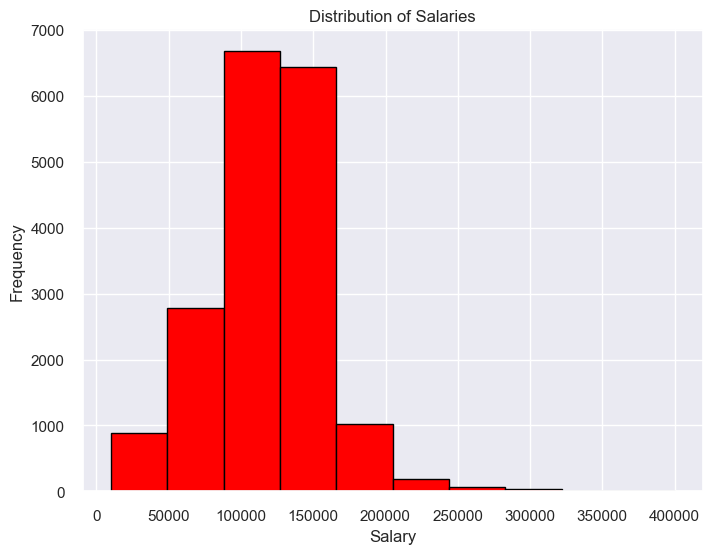

In [16]:
plt.figure(figsize=(8, 6))
plt.hist(dataframe['avg_salary'], bins=10, color='red', edgecolor='black', stacked=True)
plt.title('Distribution of Salaries')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.grid(True)
plt.show() 

### Frequency table

In [17]:
# Frequency table of salaries
avg_salaries = pd.cut(dataframe['avg_salary'], bins=10, precision=0)
frequency_table = pd.Series(avg_salaries).value_counts().sort_index()
print("Avg Salaries frequency Table:")
print(frequency_table)



Avg Salaries frequency Table:
avg_salary
(9610.0, 49000.0]        891
(49000.0, 88000.0]      2784
(88000.0, 127000.0]     6735
(127000.0, 166000.0]    6378
(166000.0, 205000.0]    1027
(205000.0, 244000.0]     181
(244000.0, 283000.0]      68
(283000.0, 322000.0]      37
(322000.0, 361000.0]       0
(361000.0, 400000.0]       2
Name: count, dtype: int64


### Mean Salaries by State

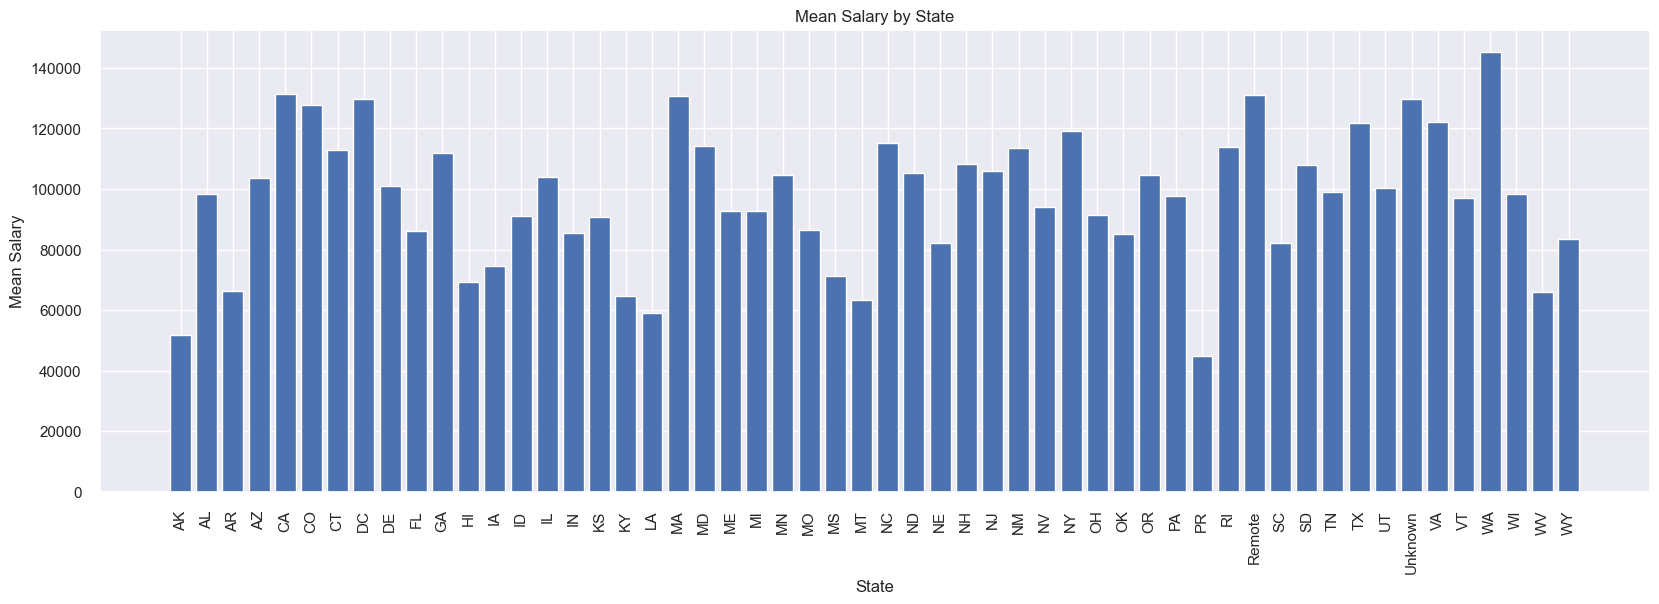

In [18]:
mean_salaries = dataframe.groupby('state')['avg_salary'].mean()

# Create a bar chart
plt.figure(figsize=(20, 6))
plt.bar(mean_salaries.index, mean_salaries.values)

plt.xlabel('State')
plt.ylabel('Mean Salary')
plt.title('Mean Salary by State')
plt.xticks(rotation=90) 

plt.show()

### Mean Salary by contract

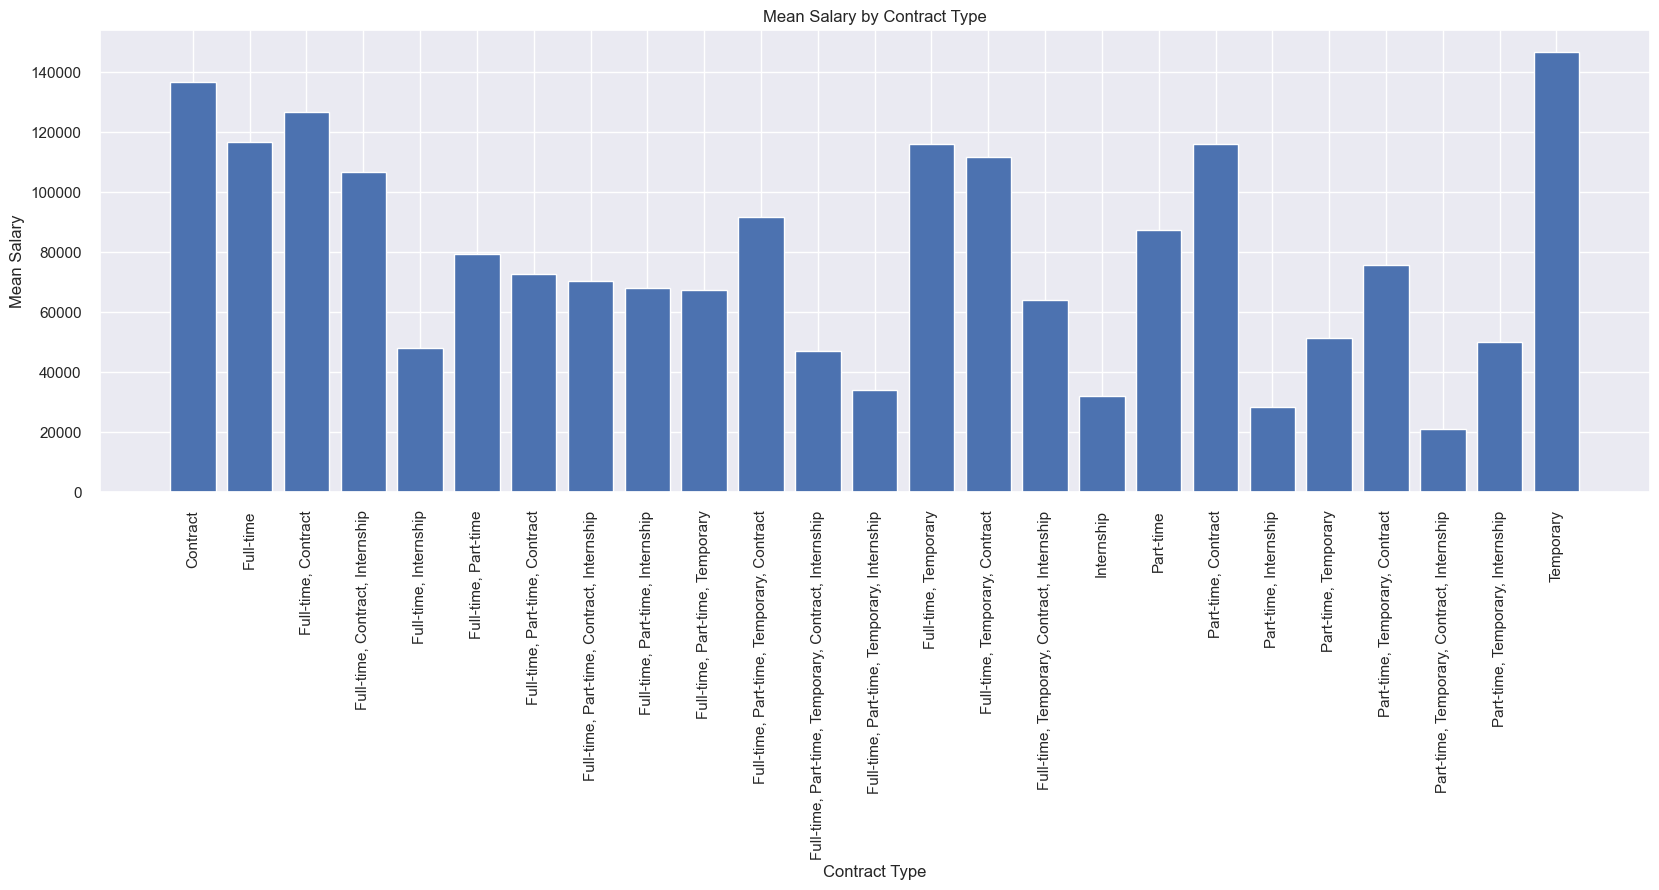

In [19]:
mean_salaries = dataframe.groupby('types')['avg_salary'].mean()

# Create a bar chart
plt.figure(figsize=(20, 6))
plt.bar(mean_salaries.index, mean_salaries.values)

plt.xlabel('Contract Type')
plt.ylabel('Mean Salary')
plt.title('Mean Salary by Contract Type')
plt.xticks(rotation=90) 

plt.show()

### Mean Salary by urgency

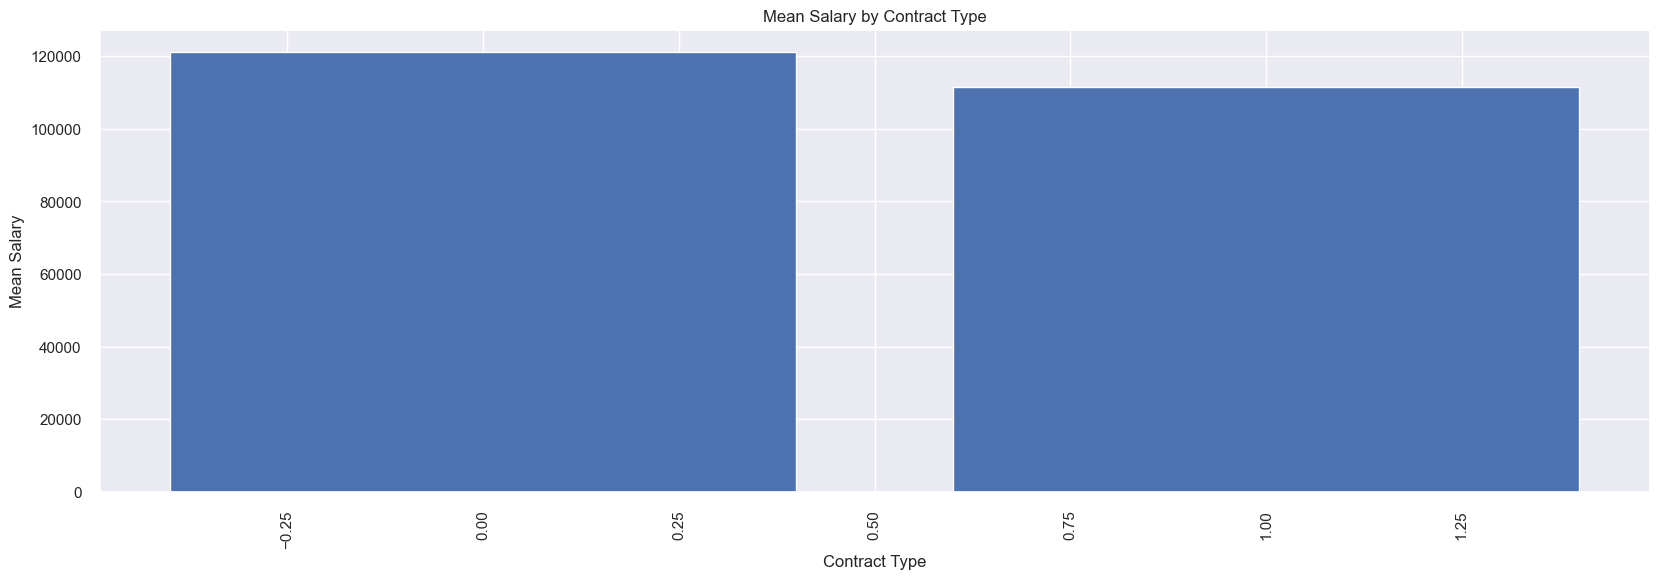

In [20]:
mean_salaries = dataframe.groupby('urgently_hiring')['avg_salary'].mean()

# Create a bar chart
plt.figure(figsize=(20, 6))
plt.bar(mean_salaries.index, mean_salaries.values)

plt.xlabel('Contract Type')
plt.ylabel('Mean Salary')
plt.title('Mean Salary by Contract Type')
plt.xticks(rotation=90) 

plt.show()

### Mean Salary by sponsorship

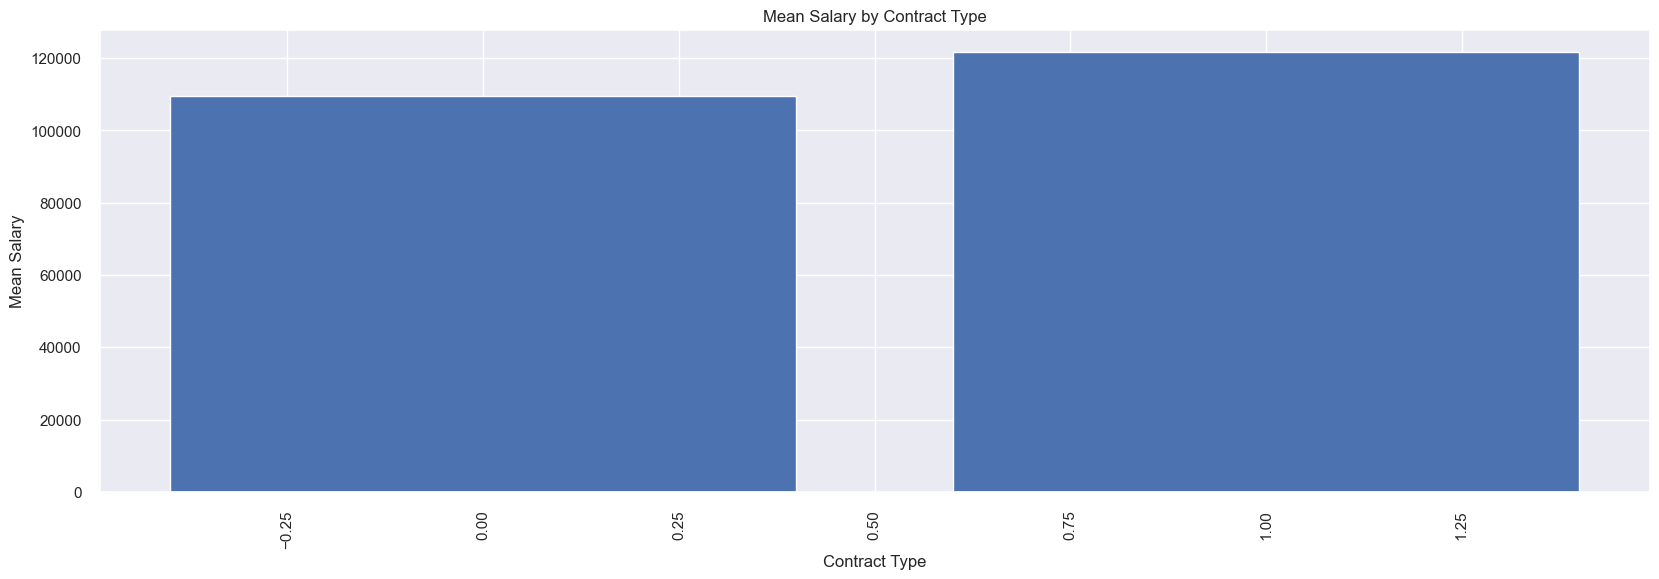

In [21]:
mean_salaries = dataframe.groupby('sponsored')['avg_salary'].mean()

# Create a bar chart
plt.figure(figsize=(20, 6))
plt.bar(mean_salaries.index, mean_salaries.values)

plt.xlabel('Contract Type')
plt.ylabel('Mean Salary')
plt.title('Mean Salary by Contract Type')
plt.xticks(rotation=90) 

plt.show()

### Box plot of salaries by location

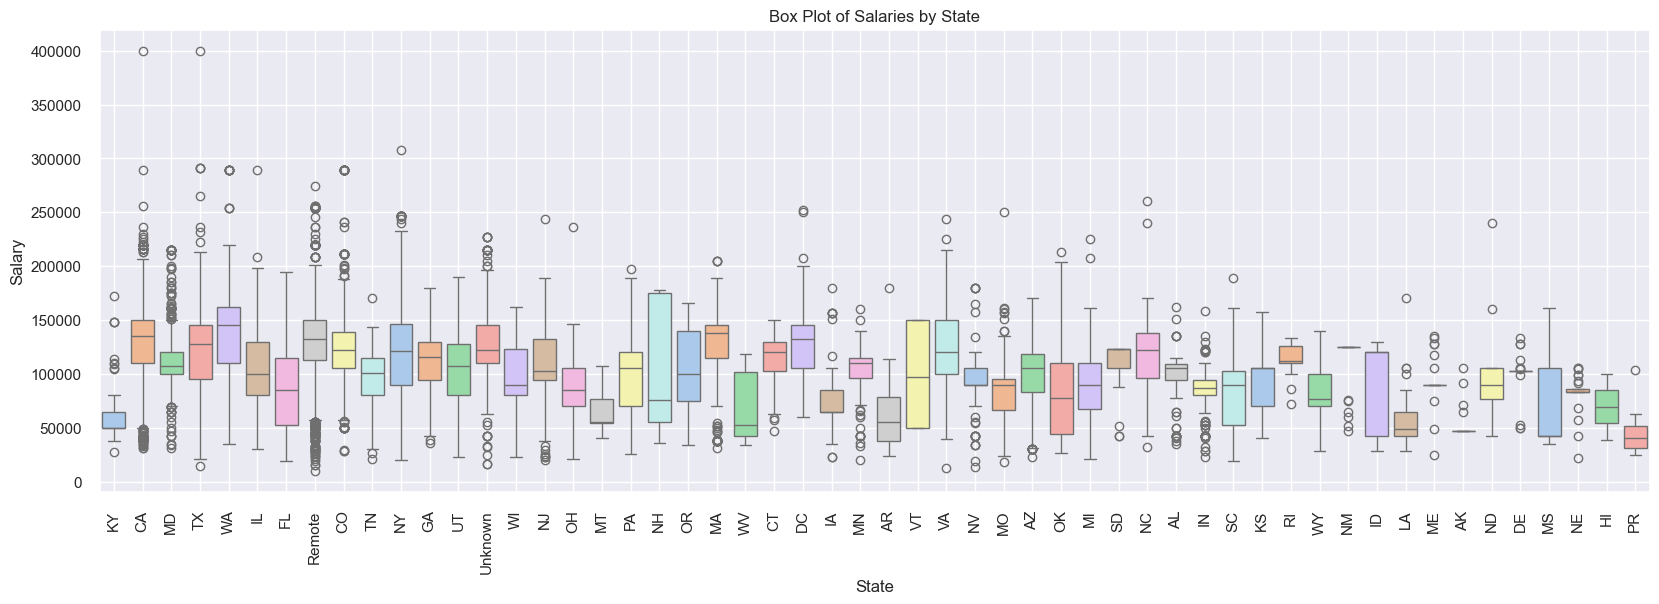

In [22]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='state', y='avg_salary', data=dataframe, palette='pastel', hue='state')
plt.title('Box Plot of Salaries by State')
plt.xlabel('State')
plt.ylabel('Salary')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

### Correlation coefficient

In [23]:
# location_mapping = {location: i for i, location in enumerate(dataframe['state'].unique())}
dataframe['state_encoded'] = dataframe['state'].astype('category').cat.codes

# Compute correlation coefficient
correlation_coefficient = dataframe['avg_salary'].corr(dataframe['state_encoded'])

print("correlation Coefficient:", correlation_coefficient)

correlation Coefficient: 0.07589354589082017


# Clustering

In [24]:
dataframe['state_encoded'] = dataframe['state'].astype('category').cat.codes
dataframe['urgency_encoded'] = dataframe['urgently_hiring'].astype('category').cat.codes
dataframe['ads_encoded'] = dataframe['sponsored'].astype('category').cat.codes

dataframe_num = dataframe[['avg_salary', 'state_encoded', 'urgency_encoded', 'ads_encoded']]

dataframe_num

,avg_salary,state_encoded,urgency_encoded,ads_encoded
1,50000,17,1,1
7,150000,4,0,1
13,156000,20,0,0
14,33110,45,1,1
17,147500,50,0,1
...,...,...,...,...
58417,162000,41,0,1
58420,150000,4,0,1
58423,162000,41,0,0
58424,162000,45,0,1


In [25]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(dataframe_num) #generates an array
df_salaries_scaled = pd.DataFrame(df_scaled) #copies into a dataframe
df_salaries_scaled.describe()

,0,1,2,3
count,1.810300e+04,1.810300e+04,1.810300e+04,1.810300e+04
mean,1.736812e-16,6.829500e-17,1.030312e-17,2.983000e-17
std,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00
min,-2.793056e+00,-1.711755e+00,-6.753106e-01,-1.541482e+00
25%,-5.982098e-01,-1.106430e+00,-6.753106e-01,-1.541482e+00
50%,4.733321e-02,3.463487e-01,-6.753106e-01,6.487265e-01
75%,6.128289e-01,7.700759e-01,1.480800e+00,6.487265e-01
max,7.277415e+00,1.496465e+00,1.480800e+00,6.487265e-01


### K-means

In [26]:
k = 3
km = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=0) #setup the k-means algorithm

In [27]:
km.fit(df_salaries_scaled)

print(km.cluster_centers_) # shows the centroids
print(km.labels_)          # shows the labels to which each point belongs

[[-0.2236651  -0.02640015 -0.0739327  -1.54148163]
 [-0.02296501 -0.12966105  1.48080011  0.64872651]
 [ 0.15111156  0.07969651 -0.67531059  0.64821526]]
[1 2 0 ... 0 2 1]


In [28]:
def visualize_clusters(data, cluster_out, clust_alg=""):
    # Reduce dimensionality of data using PCA
    pca = PCA()
    pca.fit(data)
    data_pca = pca.transform(data)

    #centers_pca = pca.transform(cluster_out.cluster_centers_)
    sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1],
                    hue=cluster_out.labels_,
                   palette="deep",alpha=0.5)
    #sns.scatterplot(centers_pca[:, 0], centers_pca[:, 1])

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(clust_alg + ' Clustering with PCA visualization')
    plt.show()

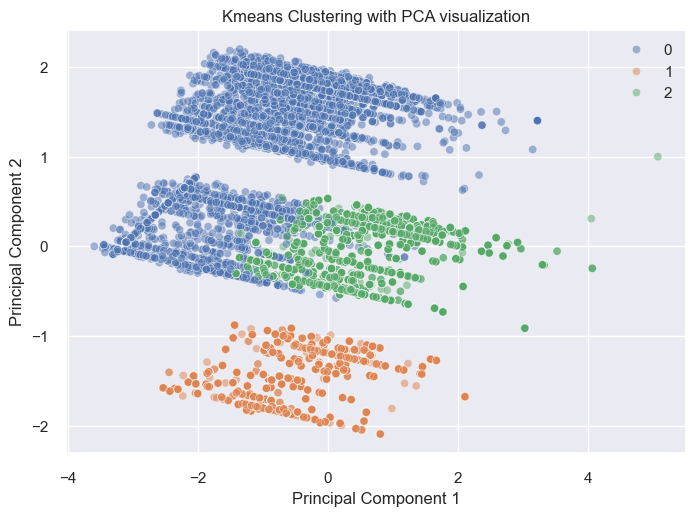

In [29]:
visualize_clusters(df_salaries_scaled, km, "Kmeans")

In [30]:
print("Avg silhouette score = ", silhouette_score(df_salaries_scaled, km.labels_))

Avg silhouette score =  0.35330832870520307


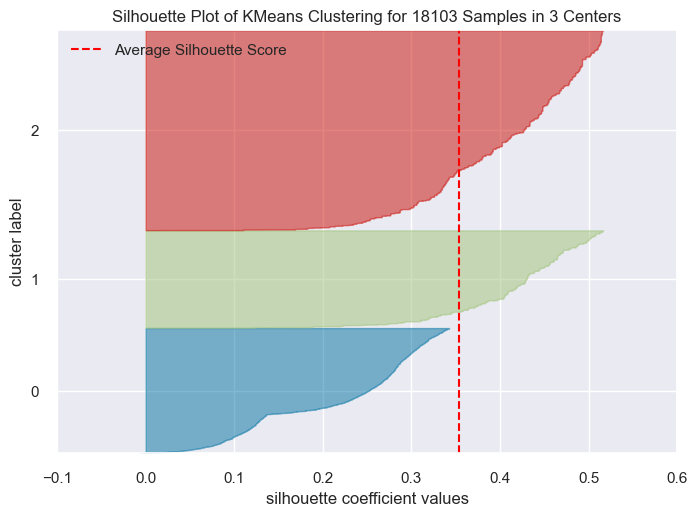

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 18103 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [31]:
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(df_salaries_scaled) # fits the data to the visualiser
visualizer.show()                      # renders the silhouette plot

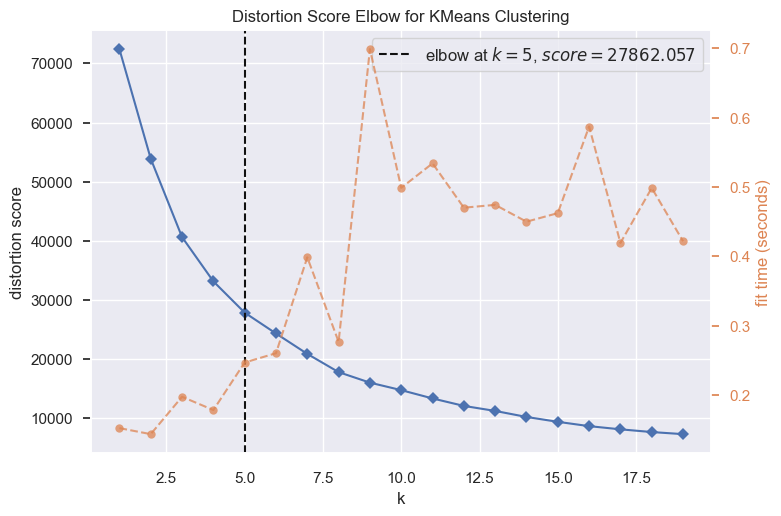

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [32]:
visualizer = KElbowVisualizer(km, k=(1, 20))
visualizer.fit(df_salaries_scaled)
visualizer.show()

In [33]:
k = 5
km = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=0)  #setup the k-means algorithm
km.fit(df_salaries_scaled)

print(km.cluster_centers_)  # shows the centroids
print(km.labels_) 

[[-0.02296501 -0.12966105  1.48080011  0.64872651]
 [-0.08004429 -0.05088568 -0.67531059 -1.54148163]
 [-0.59004437  0.03595291  1.48080011 -1.54148163]
 [ 0.21233846  0.8153518  -0.67531059  0.64831115]
 [ 0.05093678 -1.09746227 -0.67531059  0.64872651]]
[0 4 1 ... 1 3 0]


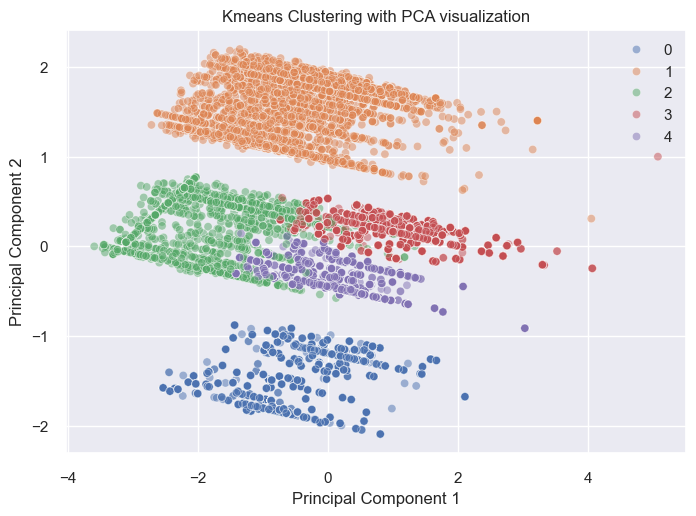

In [34]:
visualize_clusters(df_salaries_scaled, km, "Kmeans")

Avg silhouette score =  0.4018413977724915 


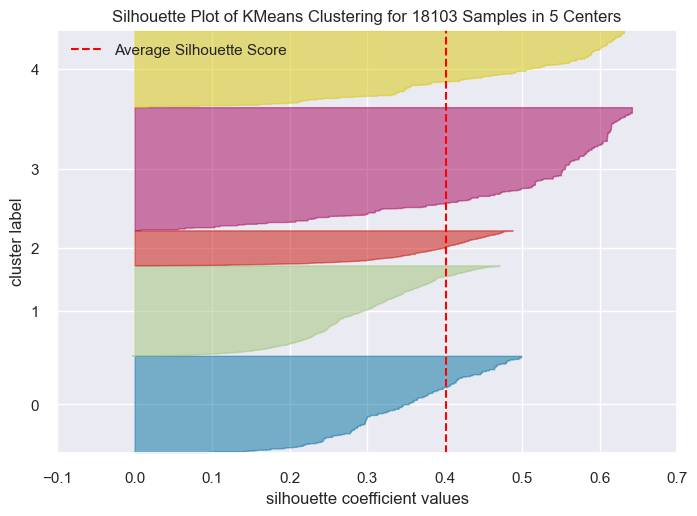

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 18103 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [35]:
print("Avg silhouette score = ", silhouette_score(df_salaries_scaled, km.labels_), "\n")

visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(df_salaries_scaled) # fits the data to the visualiser
visualizer.show()   

### DBSCAN

In [36]:
#dbscan = DBSCAN() # eps = 0.5, min_samples = 5 (default)
dbscan = DBSCAN(eps=0.5, min_samples=50) # changing the default parameters
dbscan.fit(df_salaries_scaled)

DBSCAN(min_samples=50)

In [37]:
print("Avg silhouette score = ", silhouette_score(df_salaries_scaled,dbscan.labels_))
print(dbscan.labels_)

Avg silhouette score =  0.39455831856727674
[0 1 2 ... 2 1 0]


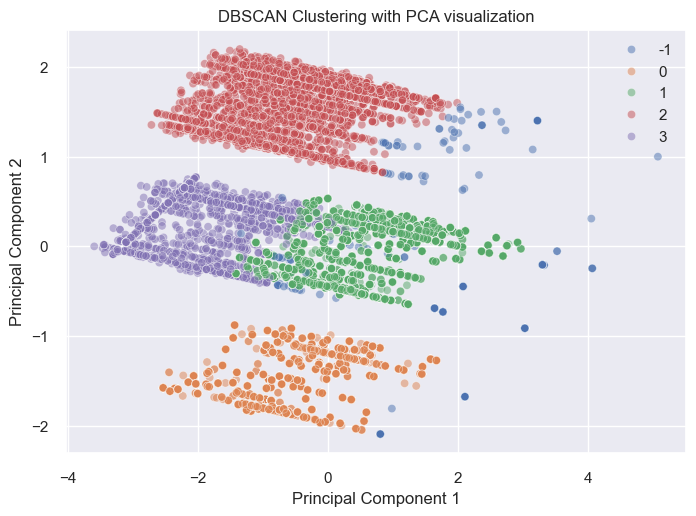

In [38]:
visualize_clusters(df_salaries_scaled, dbscan, "DBSCAN")

In [39]:
dbscan = DBSCAN(eps=0.9, min_samples=150) # changing the default parameters
dbscan.fit(df_salaries_scaled)

print("Avg silhouette score = ", silhouette_score(df_salaries_scaled,dbscan.labels_))
print(dbscan.labels_)

Avg silhouette score =  0.3932752814575732
[0 1 2 ... 2 1 0]


**The default values eps and min_samples suite quite well for this dataset**

### Agglomerative Hierarchical Clustering

In [40]:
hac=AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='single')


In [41]:
hac.fit(df_salaries_scaled)

AgglomerativeClustering(linkage='single', n_clusters=4)

In [42]:
print("Avg silhouette score = ", silhouette_score(df_salaries_scaled,hac.labels_))

Avg silhouette score =  0.3153169400293457


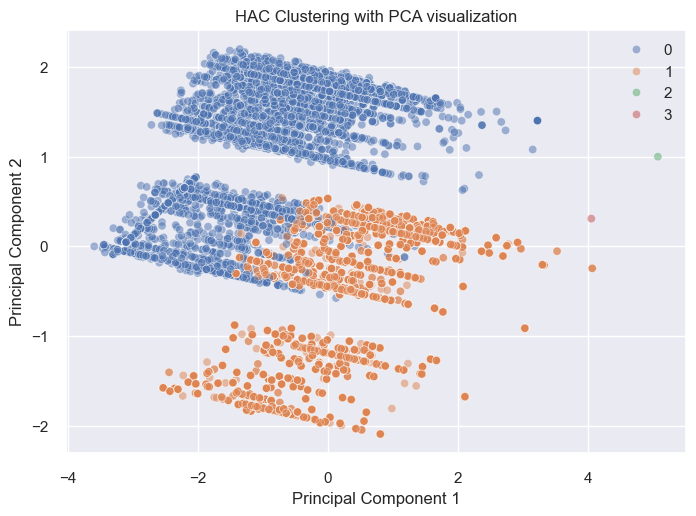

In [43]:
visualize_clusters(df_salaries_scaled, hac, "HAC")

# Linear Regression
We will split the data set to training and testing first (30% testing) 
- predictors - 'state_encoded', 'urgency_encoded', 'ads_encoded'
- target value - 'avg_salary'

In [47]:
cols = ['state_encoded', 'urgency_encoded', 'ads_encoded'];

X = dataframe_num[cols]
y = dataframe_num['avg_salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [88]:
# define a function for evaluation metrics
def evaluation_metrics(pred_value):
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred_value))
    
    # Print out the mean squared error (mse)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred_value))
    
    # Print out the root mean squared error (rmse)
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred_value)))
    
    # Print out the R-squared (R²)
    print('R-squared:', metrics.r2_score(y_test, pred_value))

In [97]:
def residuals_plot(pred):
    residuals = y_test - pred
    plt.figure(figsize=(10, 6))
    plt.scatter(gd_pred, residuals, alpha=0.5)
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Predicted values")
    plt.show()

### Linear Regression

In [48]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [49]:
# running predictions over a test set

y_pred = model.predict(X_test)

y_pred

array([114503.07435618, 103741.23167102, 109628.25986677, ...,
       116877.63254452, 113402.30979406, 126538.71066755])

### Evaluation Metrics (Linear Regression)

In [50]:
errors = abs(y_pred - y_test)

errors

10641     27650.925644
14478     49111.231671
47292      2128.259867
18325      9081.533092
56245      2698.454768
             ...      
52830     42978.397107
34420     37167.718989
58404      6877.632545
27908    129997.690206
11310     23538.710668
Name: avg_salary, Length: 5431, dtype: float64

In [89]:
evaluation_metrics(y_pred)

Mean Absolute Error: 29292.003167810162
Mean Squared Error: 1440641546.9536705
Root Mean Squared Error: 37955.78410405548
R-squared: 0.04188426070977036


### Visualisation

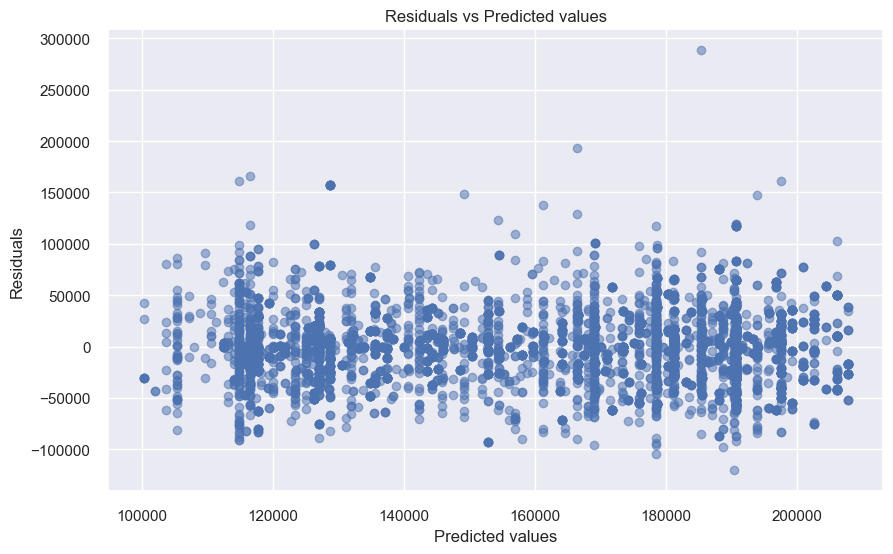

In [98]:
residuals_plot(y_pred)

### Linear Regression using Gradient Descent
Here we see R-squared really close to 0, which is awful.
Let's try to improve performance a bit

In [78]:
# gradient descent model 
gd_model = SGDRegressor(max_iter=10000)

gd_model.fit(X_train, y_train)

SGDRegressor(max_iter=10000)

In [79]:
gd_pred = gd_model.predict(X_test)

gd_pred

array([178407.14812877, 157021.02693811, 125142.93413876, ...,
       176121.85109713, 166379.74496973, 185480.56912875])

### Evaluation Metrics (Gradient Descent)

In [61]:
gd_errors = abs(gd_pred - y_test)

gd_errors

10641     61030.413919
14478     21811.294792
47292      5703.246729
18325     42311.759795
56245     24540.144866
             ...      
52830      6762.308945
34420      3113.363844
58404     23569.556528
27908    157608.279392
11310      7219.130712
Name: avg_salary, Length: 5431, dtype: float64

In [90]:
evaluation_metrics(gd_pred)

Mean Absolute Error: 53215.32477246951
Mean Squared Error: 4054696324.650458
Root Mean Squared Error: 63676.49742762598
R-squared: -1.6966238582419444


It is a bit odd that R-square is negative (with 1k iterations)

But MEA and RMSE are a little worse than regular regression

Applying 30k iteration gave us similar result compared to simple Linear Regression

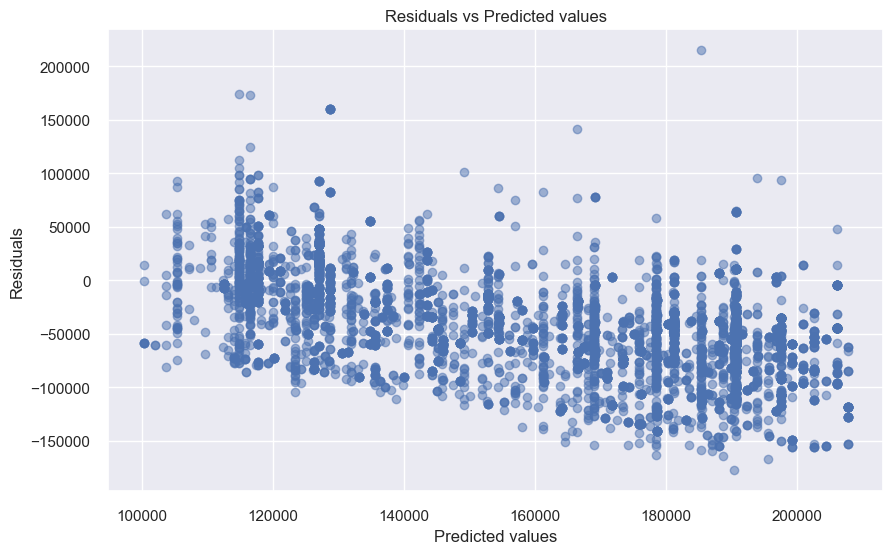

In [99]:
residuals_plot(gd_pred)

# Regression Trees

### Decision Tree first attempt

In [140]:
# Create a DecisionTreeRegressor object
tree = DecisionTreeRegressor(max_depth=3)

# Fit the model to the training data
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [141]:
tree_pred = tree.predict(X_test)

tree_pred

array([118619.71300448, 109363.45785503,  94562.24842105, ...,
       109363.45785503, 109363.45785503, 109363.45785503])

### Evaluation Metrics (Decision Tree)

In [142]:
evaluation_metrics(tree_pred)

Mean Absolute Error: 27605.448877834242
Mean Squared Error: 1314017088.378978
Root Mean Squared Error: 36249.37362740187
R-squared: 0.1260973579899768


The R-squared metric is much better for this method

### Visualisation

In [143]:
# plot the tree
viz = dtreeviz.model(
    model=tree,
    X_train=X_train,
    y_train=y_train,
    target_name='avg_salary',
    feature_names=cols)

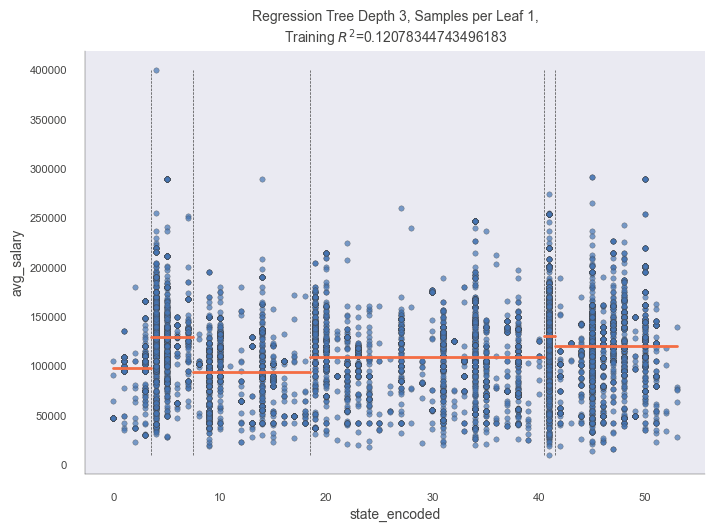

In [144]:
viz.rtree_feature_space(features=['state_encoded'])

In [146]:
# viz.rtree_feature_space3D(features=['state_encoded','urgency_encoded'],
#                                  fontsize=10,
#                                  elev=30, azim=20,
#                                  show={'splits', 'title'},
#                                  colors={'tessellation_alpha': .5})

### Improvements
Let's start from tuning model parameters

`max_depth`: The maximum depth of the tree. Reducing this can help to prevent overfitting.
`min_samples_split`: The minimum number of samples required to split an internal node. Increasing this can prevent the model from learning too detailed relations which might only hold in the training data.
`min_samples_leaf`: The minimum number of samples required to be at a leaf node. Similar to min_samples_split, increasing this can help to prevent overfitting.
`max_features`: The number of features to consider when looking for the best split. Trying different values might lead to better results.

We will choose the best set of params using GridSearchCV

In [104]:
# Define the parameter grid
param_grid = {
    'max_depth': [10, 20, 30, 40],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt']
}

# Create a DecisionTreeRegressor object
tree2 = DecisionTreeRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=tree2, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Create a new DecisionTreeRegressor object with the best parameters
best_tree = DecisionTreeRegressor(**best_params)

# Fit the new model to the data
best_tree.fit(X_train, y_train)

# Make predictions with the new model
best_pred = best_tree.predict(X_test)

### Evaluation Metrics with best params

In [102]:
evaluation_metrics(best_pred)

Mean Absolute Error: 24711.518976967327
Mean Squared Error: 1113307678.0526755
Root Mean Squared Error: 33366.26556947414
R-squared: 0.2595815306934005


### Visualisation with best params

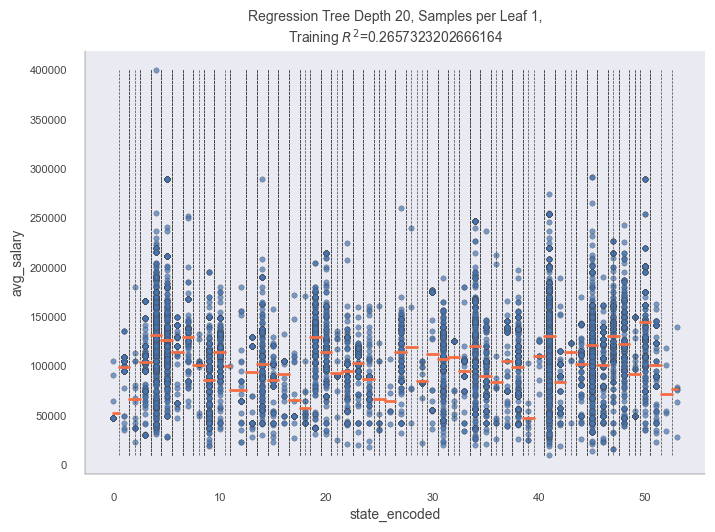

In [148]:
# plot the tree
viz = dtreeviz.model(
    model=best_tree,
    X_train=X_train,
    y_train=y_train,
    target_name='avg_salary',
    feature_names=cols)
viz.rtree_feature_space(features=['state_encoded'])

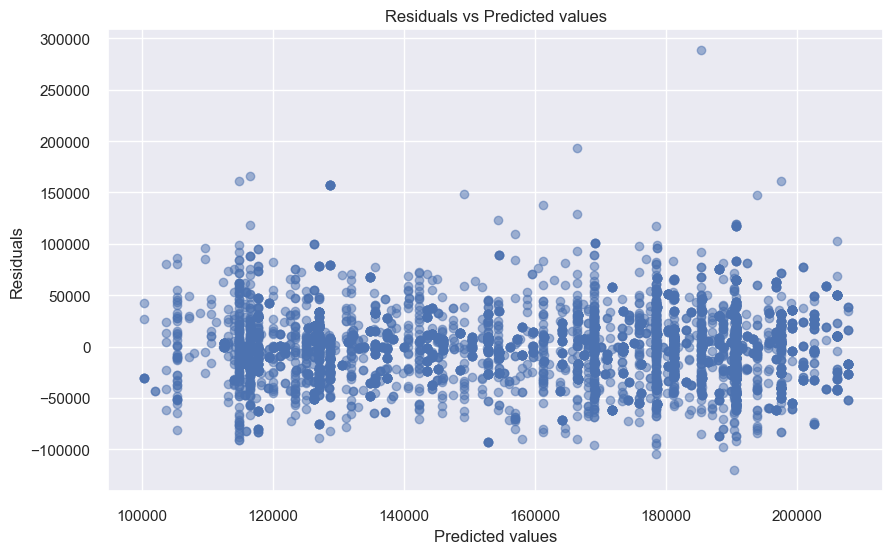

In [103]:
residuals_plot(best_pred)